# Recursion Cellular Image Classification 
## - Ensemble & Leakage Use & Visualization

* Thanks greatly to [this kaggle kernel](https://www.kaggle.com/tanlikesmath/rcic-fastai-starter)
* I'm kicking myself for seeing the [plate leak](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/102905#latest-624588) 2 days before closing of the competition.
* For plate leak, I only managed to apply the group as 277hot-encoding mask, didn't have the time experimenting new model structure on it
* My trainings are based on the above efficient net b3, b4, and b5, densenet 121 and 202
* This is the ensemble of those model weights, my final results are based on various version of efficient net b5

## Load modules

In [1]:
import os

import numpy as np
import pandas as pd

from fastai.vision import *
from fastai.metrics import *

In [2]:
torch.cuda.is_available()

True

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

SEED = 0
seed_everything(SEED)

## Loading and formatting data

Here I will load the csv into the DataFrame, and create a column in the DataFrame with the path to the corresponding image (`generate_df`)

In [5]:
from pathlib import Path

DATA = Path("/mnt/disk4/cell/")

In [6]:
train_df = pd.read_csv(DATA/'train.csv')
train_df.head(10)

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144
5,HEPG2-01_1_B08,HEPG2-01,1,B08,503
6,HEPG2-01_1_B09,HEPG2-01,1,B09,188
7,HEPG2-01_1_B10,HEPG2-01,1,B10,700
8,HEPG2-01_1_B11,HEPG2-01,1,B11,1100
9,HEPG2-01_1_B12,HEPG2-01,1,B12,611


In [7]:
def generate_df(train_df,sample_num=1):
    train_df['path'] = train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(sample_num) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df
site1_train_df = generate_df(train_df)  
site2_train_df = generate_df(train_df, sample_num=2)

proc_train_df = pd.concat([site1_train_df,site2_train_df],axis=0 )\
.sample(frac = 1.0)\
.reset_index()\
.drop("index",axis=1)

Let's look at an example image. These images are 6-channel images, but the each of the six channels are saved as separate files. Here, I open just one channel of the image.

In [8]:
proc_train_df.head(10)

,path,sirna
0,HUVEC-15/Plate4/G13_s2_w,981
1,RPE-04/Plate4/B19_s1_w,954
2,HEPG2-05/Plate3/H14_s1_w,757
3,RPE-04/Plate4/F05_s2_w,803
4,HUVEC-14/Plate2/B13_s2_w,1004
5,RPE-01/Plate1/B03_s1_w,1084
6,HUVEC-13/Plate1/K19_s2_w,678
7,U2OS-02/Plate2/B17_s2_w,357
8,HUVEC-08/Plate1/O13_s2_w,1100
9,HUVEC-02/Plate1/B22_s2_w,301


In [9]:
import cv2
img = cv2.imread(str(DATA/"train/HEPG2-01/Plate1/B03_s1_w2.png"))
# plt.imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray_img)
gray_img.shape

(512, 512)

In fastai, there is a modular data API that allows you to easily load images, add labels, split into train/valid, and add transforms. The base class for loading the images is an `ItemList`. For image classification tasks, the base class is `ImageList` which in turn subclasses the `ItemList` class. Since `ImageList` can only open 3-channel images, we will define a new `ImageList` class where we redefine the loading function:

In [10]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)

As I subclassed the ImageList function I can load images with the `ImageList` function `.from_df`. 

In [11]:
il = MultiChannelImageList.from_df(df=proc_train_df,path=DATA/'train/')

We have to redefine the following function to be able to view the image in the notebook. I view just the first 3 channels.

In [12]:
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np

Now let's view an example image:

In [13]:
# il[0]

With the multi-channel `ImageList` defined, we can now create a DataBunch of the train images. Let's first create a stratified split of dataset and get the indices. 

In [14]:
from sklearn.model_selection import StratifiedKFold
#train_idx, val_idx = next(iter(StratifiedKFold(n_splits=int(1/0.035),random_state=42).split(proc_train_df, proc_train_df.sirna)))
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(proc_train_df,test_size=0.035, stratify = proc_train_df.sirna, random_state=42)
_proc_train_df = pd.concat([train_df,val_df])

Now we create the `DataBunch`

In [15]:
# data.show_batch()

## Creating and Training a Model

I will use a pretrained EfficientNet. There is code for other models thatt you can try but the EfficientNet seems to do the best. I have to now adjust the CNN arch to take in 6 channels as opposed to the usual 3 channels:

In [16]:
# !pip install efficientnet_pytorch

In [17]:
from efficientnet_pytorch import *

In [18]:
"""Inspired by https://github.com/wdhorton/protein-atlas-fastai/blob/master/resnet.py"""

import torchvision
RESNET_MODELS = {
    18: torchvision.models.resnet18,
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

def resnet_multichannel(depth=50,pretrained=True,num_classes=1108,num_channels=6):
        model = RESNET_MODELS[depth](pretrained=pretrained)
        w = model.conv1.weight
        model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        model.conv1.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
        return model

    
DENSENET_MODELS = {
    121: torchvision.models.densenet121,
    161: torchvision.models.densenet161,
    169: torchvision.models.densenet169,
    201: torchvision.models.densenet201,
}

def densenet_multichannel(depth=121,pretrained=True,num_classes=1108,num_channels=6):
    model = DENSENET_MODELS[depth](pretrained=pretrained)
    
    w = model.features.conv0.weight
    model.features.conv0 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
    model.features.conv0.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
    
    class dnNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.features = model.features
            self.classifier = nn.Linear(model.classifier.weight.data.size(1), num_classes)
            for m in self.modules():
                if isinstance(m, nn.Conv2d):nn.init.kaiming_normal(m.weight.data)
                elif isinstance(m, nn.BatchNorm2d):m.weight.data.fill_(1);m.bias.data.zero_()
                elif isinstance(m, nn.Linear):m.bias.data.zero_()
            
        def forward(self,x):
            features = self.features(x)
            out = F.relu(features, inplace=True)
            out = F.avg_pool2d(out, kernel_size=14, stride=1).view(features.size(0), -1)
            out = self.classifier(out)
            return out
    dn_model = dnNet()
    return dn_model


def efficientnet_multichannel(pretrained=True,name='b3',num_classes=1108,num_channels=6,image_size=360):
    model = EfficientNet.from_pretrained('efficientnet-'+name,num_classes=num_classes)
    #model.load_state_dict(torch.load(EFFICIENTNET_MODELS[name]))
    w = model._conv_stem.weight
    #s = model._conv_stem.static_padding
    model._conv_stem = utils.Conv2dStaticSamePadding(num_channels,32,kernel_size=(3, 3), stride=(2, 2), bias=False, image_size = image_size)
    model._conv_stem.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
    return model

In [19]:
def resnet18(pretrained,num_channels=6):
    return resnet_multichannel(depth=18,pretrained=pretrained,num_channels=num_channels)

def _resnet_split(m): return (m[0][6],m[1])

def densenet(name,pretrained=True,num_channels=6):
    return densenet_multichannel(depth=int(name.replace("dn","")),pretrained=pretrained,num_channels=num_channels)
  
def _densenet_split(m:nn.Module): return (m[0][0][7],m[1])

def efficientnetbn(name, sz, pretrained=True,num_channels=6):
    return efficientnet_multichannel(pretrained=pretrained,name=name, num_channels=num_channels, image_size = sz)

def getModel(name,sz):
    if name in list("b%s"%(i) for i in range(6)):
        return efficientnetbn(name = name,sz = sz)
    elif name in ["dn121","dn169","dn161","dn201"]:
        return densenet(name)


## Inference and Submission Generation

Let's now load our test csv and process the DataFrame like we did for the training data.

In [20]:
test_df = pd.read_csv(DATA/'test.csv')
site1_test_df = generate_df(test_df.copy())
site2_test_df = generate_df(test_df.copy(),sample_num=2)

In [21]:
test_df["pname"] = test_df.apply(lambda x:x["experiment"]+"-"+x["plate"].__str__(), axis=1)

Prediction on a single model/ with single site test data

In [22]:
# !mkdir -p /data/rcic/saved_preds

In [23]:
# cache for predicting, 
PREDS = Path("/data/rcic/saved_preds")
def predCache(f):
    """
    prediction cache decorator
    # if model weights and infered site are the same, load the saved prediction tensor 
    """
    def func(**kwargs):
        saved_fn = "%s_site-%s.tsr"%(kwargs["load"].split(".")[0],kwargs["site"])
        save_path = str(PREDS/saved_fn)
        if os.path.exists(save_path):
            print("loading from cache: %s"%(save_path))
            return torch.load(save_path)
        else:
            pred = f(**kwargs) # running the prediciton
            torch.save(pred, save_path)
            print("save to cache: %s"%(save_path))
            return pred
    return func

In [24]:
@predCache
def getPred(name,sz,bs,load,site):
    """
    get prediction for 2 sites using a pretrained model
    name: str, in 'b0','b1','b2','b3'...,'b5'
    site: 1 or 2
    """
    site_test_df=site1_test_df if site==1 else site2_test_df
    data_test = MultiChannelImageList.from_df(df = site_test_df,path=DATA/'test/')
    data = (MultiChannelImageList.from_df(df=_proc_train_df,path=DATA/'train/')
        .split_by_idx(list(range(len(train_df),len(_proc_train_df))))
        .label_from_df()
        .transform(get_transforms(),size=sz)
        .databunch(bs=bs,num_workers=4)
        .normalize()
       )
    learn = Learner(data, getModel(name,sz),metrics=[accuracy]).to_fp16()
    learn.path = Path("./ensemble")
    learn.load(load)
    learn.data.add_test(data_test)
    preds, _ = learn.get_preds(DatasetType.Test)
    return preds

Ensemble the prediction

In [25]:
groups = np.load("groups.npy")
groups

array([0., 1., 2., 1., ..., 1., 3., 1., 0.])

In [26]:
groups_oh = np.eye(4)[groups.astype(np.int)]
groups_oh[:10,:]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [110]:
def ensemble(*args,pred_mask=np.ones((len(test_df),1108))):
    """
    ensemble the model by averaging the output probability
    args: prediction tensors
    """
    preds = list(args)
    preds_len = len(preds)
    all_preds = sum(preds)*torch.Tensor(pred_mask)
    preds_idx = (all_preds/preds_len).argmax(dim=-1)
    return preds_idx

def argmaxEnsemble(*args):
    """
    ensemble the model by taking the most confident output
    args: prediction tensors
    """
    preds = list(args)
    preds_len = len(preds)
    preds_idx = torch.max(torch.stack(preds),dim=0)[0].argmax(dim=-1)
    return preds_idx
    

def calcGroupDict(pred_tensors,bm=0.5):
    final = []
    for idx in range(len(pred_tensors)):
        # for each prediction tensor, guess a version of "plate => belongs to a group"
        p = pred_tensors[idx]
        gbtest = test_df.copy()
        gbtest["projected"] = p.argmax(dim=-1).numpy()
        gbtest["group_"] = gbtest["projected"].apply(lambda x:groups[x])
        # for each plate, the biggest frequence count group owns the plate
        group_df = pd.DataFrame(gbtest.groupby("pname")\
        .apply(lambda x:x.group_.value_counts().reset_index().loc[0]["index"])).rename(columns={0:idx})
        if len(final)!=0:
            final = final.join(group_df)
        else:
            final = group_df
            
    # Check the magnitude of agreement on each gruop
    # We'll apply group mask only if more than 50% percent of the models agree
    cat_validation = (np.eye(4)[final.values.astype(np.int)].sum(axis=-2)/len(pred_tensors)>bm) 
    # What's the group mask this plate is it's going to use
    force_group =  dict(zip(final.index,list(cat_validation.argmax(axis=-1)))) 
    # Is this plate apply to the plate mask
    is_force = dict(zip(final.index,list(cat_validation.sum(axis=-1)))) 
    return force_group, is_force,final

In [351]:
pred_tensors = list()

Our ensemble pool

In [352]:
pred_tensors.append(getPred(name = "b0",sz = 256, bs = 64,load = "rcic-b0-sz256-bs64-s12", site = 1)) #0.272

pred_tensors.append(getPred(name = "b0",sz = 256, bs = 64,load = "rcic-b0-sz256-bs64-s12", site = 2))

pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-b3-s320-bs16-s12", site = 1)) # 0.378

pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-b3-s320-bs16-s2-e1", site = 2)) # 0.329

pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-b3-s320-bs16-s2-e_end", site = 2)) # 0.390

# pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-b3-sz320-bs16-s1-e54" , site = 2)) # 0.389

pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-ps-b3-sz320-bs16-s12" , site = 1)) # 0.405

pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-ps-b3-sz320-bs16-s12" , site = 2)) # N/A

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-b4-sz380-bs36-s1", site = 1)) # 0.325

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-b4-sz380-bs36-s2", site = 2)) # 0.326

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-b4-sz380-bs36-s1-stage-2", site = 1)) # 0.339

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-b4-sz380-bs36-s2-stage-2", site = 2)) # 0.340

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-ps-b4-sz380-bs24-s1", site = 1)) # 0.368

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-ps-b4-sz380-bs24-s2", site = 2)) # 0.376
# ======================
pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs26-s1-s2", site = 1)) # 0.459

pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs26-s1-s2", site = 2)) # 0.417

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-ps-b4-sz380-bs24-s1-r2", site = 1)) # 0.42

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-ps-b4-sz380-bs24-s1-r2uf", site = 1))

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-ps-b4-sz380-bs24-s2-r2", site = 2)) # 0.45

pred_tensors.append(getPred(name = "b4",sz = 380, bs = 16,load = "rcic-ps-b4-sz380-bs24-s2-r2uf", site = 2)) # 0.373

pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs26-s1-s2-r2", site = 1)) # 0.498

# pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs26-s1-s2-r2", site = 2)) # 0.496

pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs26-s3-psewdo-r2", site = 1)) # 0.496

pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs26-s3-psewdo-r2", site = 2)) # 0.500

pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs28-s2-r2", site = 2)) # 0.490

pred_tensors.append(getPred(name = "b5",sz = 456, bs = 12,load = "rcic-b5-sz456-bs26-s1-pseudo-r2", site = 1)) # 0.480
 
pred_tensors.append(getPred(name = "b5",sz = 456, bs = 16,load = "rcic-b5-sz456-bs26-s3-psewdo-r3", site = 1)) # 0.437



loading from cache: /data/rcic/saved_preds/rcic-b0-sz256-bs64-s12_site-1.tsr
loading from cache: /data/rcic/saved_preds/rcic-b0-sz256-bs64-s12_site-2.tsr
loading from cache: /data/rcic/saved_preds/rcic-b3-s320-bs16-s12_site-1.tsr
loading from cache: /data/rcic/saved_preds/rcic-b3-s320-bs16-s2-e1_site-2.tsr
loading from cache: /data/rcic/saved_preds/rcic-b3-s320-bs16-s2-e_end_site-2.tsr
loading from cache: /data/rcic/saved_preds/rcic-ps-b3-sz320-bs16-s12_site-1.tsr
loading from cache: /data/rcic/saved_preds/rcic-ps-b3-sz320-bs16-s12_site-2.tsr
loading from cache: /data/rcic/saved_preds/rcic-b4-sz380-bs36-s1_site-1.tsr
loading from cache: /data/rcic/saved_preds/rcic-b4-sz380-bs36-s2_site-2.tsr
loading from cache: /data/rcic/saved_preds/rcic-b4-sz380-bs36-s1-stage-2_site-1.tsr
loading from cache: /data/rcic/saved_preds/rcic-b4-sz380-bs36-s2-stage-2_site-2.tsr
loading from cache: /data/rcic/saved_preds/rcic-ps-b4-sz380-bs24-s1_site-1.tsr
loading from cache: /data/rcic/saved_preds/rcic-ps-b

In [353]:

# pred_tensors.append(getPred(name = "b5",sz = 456, bs = 32,load = "rcic-b5-sz456-bs26-s3-psewdo-r3", site = 2))

In [354]:
if len(pred_tensors)>1:
    force_group, is_force,final_df = calcGroupDict(pred_tensors,bm=0.5)
    
    test_df["force_group"] = test_df["pname"].apply(lambda x:force_group[x])# this row of image => infered group
    test_df["is_force"] = test_df["pname"].apply(lambda x:is_force[x]) # this row of image => use group mask?
    test_df["group_mask"] = test_df["force_group"].apply(lambda x:groups_oh[:,x])
    
    # create an image based mask
    pred_mask = np.stack(test_df["group_mask"])
    # nullify the mask effect (change 0 back to 1) if preds are indecisive between each other
    pred_mask[~test_df.is_force.astype(np.bool)]=1.
else:
    # a mask of ones = not apply any mask
    pred_mask = np.ones((len(test_df),1108))

print(pred_mask.mean())

0.25


In [355]:
# force_group, is_force, final_df = calcGroupDict(pred_tensors, bm=0.6)

In [356]:
all_list = ['HEPG2-08-1','HEPG2-08-2','HEPG2-08-3','HEPG2-08-4','HEPG2-09-1', 'HEPG2-09-2','HEPG2-09-3', 'HEPG2-09-4','HEPG2-10-1', 'HEPG2-10-2',
'HEPG2-10-3','HEPG2-10-4','HEPG2-11-1', 'HEPG2-11-2','HEPG2-11-3', 'HEPG2-11-4','HUVEC-17-1', 'HUVEC-17-2',
'HUVEC-17-3', 'HUVEC-17-4','HUVEC-18-1','HUVEC-18-2', 'HUVEC-18-3','HUVEC-18-4','HUVEC-19-1','HUVEC-19-2',
 'HUVEC-19-3','HUVEC-19-4','HUVEC-20-1','HUVEC-20-2', 'HUVEC-20-3','HUVEC-20-4','HUVEC-21-1', 'HUVEC-21-2', 'HUVEC-21-3',
 'HUVEC-21-4', 'HUVEC-22-1', 'HUVEC-22-2', 'HUVEC-22-3', 'HUVEC-22-4','HUVEC-23-1',
 'HUVEC-23-2', 'HUVEC-23-3', 'HUVEC-23-4','HUVEC-24-1', 'HUVEC-24-2', 'HUVEC-24-3','HUVEC-24-4', 'RPE-08-1', 'RPE-08-2',
 'RPE-08-3','RPE-08-4', 'RPE-09-1','RPE-09-2','RPE-09-3','RPE-09-4', 'RPE-10-1', 'RPE-10-2', 'RPE-10-3', 'RPE-10-4', 'RPE-11-1','RPE-11-2', 'RPE-11-3','RPE-11-4', 'U2OS-04-1', 'U2OS-04-2', 'U2OS-04-3',
 'U2OS-04-4', 'U2OS-05-1', 'U2OS-05-2', 'U2OS-05-3', 'U2OS-05-4'
]
# The plate we are not sure which group
problem_list = ["U2OS-04-2","U2OS-04-4"]

In [357]:
final = []
for idx in range(len(pred_tensors)):
        # for each prediction tensor, guess a version of "plate => belongs to a group"
    p = pred_tensors[idx]
    gbtest = test_df.copy()
    gbtest["projected"] = p.argmax(dim=-1).numpy()
    gbtest = gbtest[gbtest.pname.isin(all_list)]
    gbtest["group_"] = gbtest["projected"].apply(lambda x:groups[x])
        # for each plate, the biggest frequence count group owns the plate
    group_df = pd.DataFrame(gbtest.groupby("pname")\
    .apply(lambda x:x.group_.value_counts().reset_index())).reset_index().rename(columns={"group_":idx})
    group_df["pg_name"] = group_df.apply(lambda x:x["pname"]+"-"+str(int(x["index"])),axis=1)
    group_df = group_df.drop(["pname","level_1","index"],axis=1).set_index("pg_name")
#     print(group_df)
    if len(final)==0:
        final = group_df
    else:
        final = final.join(group_df)

In [358]:
final

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
pg_name,,,,,,,,,,,,,,,,,,,,,
HEPG2-08-1-0,116,122.0,121,117,196,142,136,155,92,125,...,192,188,140,167,202,226.0,214,211,216,207
HEPG2-08-1-2,69,65.0,55,60,31,53,51,50,56,56,...,40,40,44,53,24,25.0,31,30,21,25
HEPG2-08-1-1,60,36.0,60,50,19,24,33,27,40,49,...,23,24,70,32,29,14.0,15,16,20,33
HEPG2-08-1-3,32,54.0,41,50,31,58,57,45,89,47,...,22,25,23,25,22,12.0,17,20,20,12
HEPG2-08-2-1,94,90.0,132,98,154,56,77,132,97,125,...,166,153,137,189,180,170.0,182,168,193,193
HEPG2-08-2-3,74,46.0,54,64,29,94,79,55,74,48,...,36,37,28,12,34,26.0,28,33,25,25
HEPG2-08-2-2,66,63.0,46,81,49,49,65,55,60,60,...,55,56,60,41,35,33.0,35,31,25,21
HEPG2-08-2-0,43,78.0,45,34,45,78,56,35,46,44,...,20,31,52,35,28,48.0,32,45,34,38
HEPG2-08-3-2,159,166.0,132,210,217,141,134,202,109,174,...,216,211,156,203,197,209.0,243,212,206,201


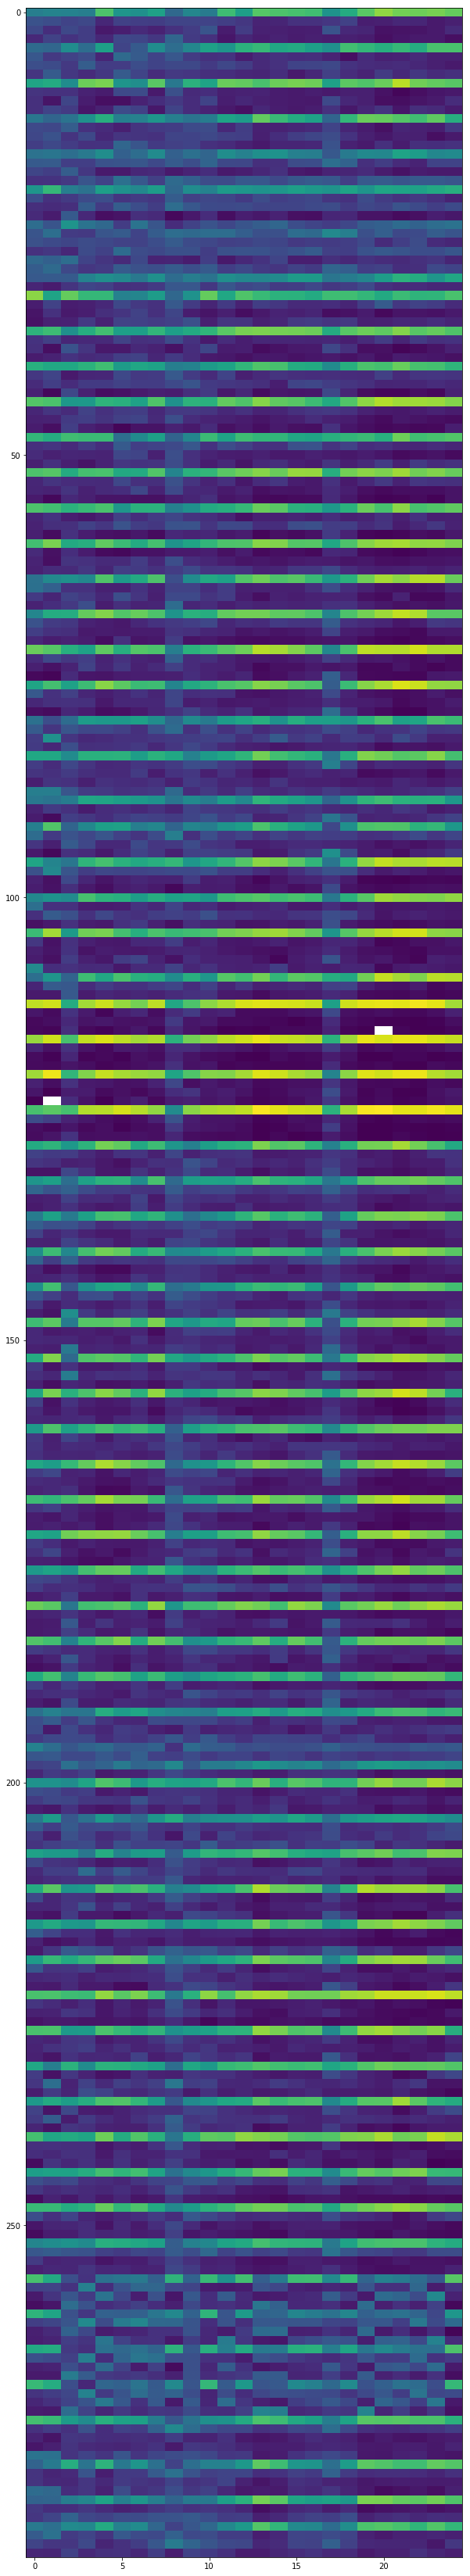

In [359]:
plt.figure(figsize = (10,60))
plt.imshow(final.values, interpolation="nearest", aspect="auto")

In [326]:
from collections import Counter
dict(Counter(list(force_group.values())))

{0: 18, 1: 17, 2: 20, 3: 17}

In [327]:
# preds = argmaxEnsemble(*pred_tensors) # This way of ensemble isn't as good as "average probability ensemble"
preds = ensemble(*pred_tensors, pred_mask=pred_mask)

In [328]:
def ensembleVote(*args, pred_mask=pred_mask, min_agree = 0.4):
    preds = list(args)
    preds_len = len(preds)
    mask_tensor =torch.Tensor(pred_mask)
    single_idx = []
    for pred in preds:
        single_idx.append((pred*mask_tensor).argmax(dim=-1))
    single_indices = torch.stack(single_idx)
    vote_portion,vote_indices = torch.max(torch.eye(1108)[single_indices.T].mean(-2),dim=-1)
    use_vote = vote_portion>min_agree
    use_vote_ratio = (use_vote).float().mean().item()
    print(use_vote_ratio)
    # none vote pred for indecisive votes
    all_preds = sum(preds)* mask_tensor
    preds_sum_idx = (all_preds/preds_len).argmax(dim=-1)
    
    vote_indices[~use_vote]=preds_sum_idx[~use_vote]
    
    return vote_indices, vote_portion

In [329]:
preds, vote_portion =ensembleVote(*pred_tensors, pred_mask=pred_mask)

0.9115444421768188


### Save to submission file

The following nb is also from the starter notebook

In [330]:
submission_df = pd.read_csv(DATA/'sample_submission.csv')

In [331]:
submission_df.sirna = preds.numpy().astype(int)
print(submission_df.head(5))

          id_code  sirna
0  HEPG2-08_1_B03    855
1  HEPG2-08_1_B04    710
2  HEPG2-08_1_B05    836
3  HEPG2-08_1_B06    596
4  HEPG2-08_1_B07    201


In [332]:
submission_df.to_csv('submission.csv',index=False)

Our hopeless models

In [212]:
# pred_tensors.append(getPred(name = "dn121",sz = 456, bs = 16,load = "rcic-dn121-sz448-bs26-s3", site = 1)) # 0.159

# pred_tensors.append(getPred(name = "dn121",sz = 456, bs = 16,load = "rcic-dn121-sz448-bs26-s3", site = 2)) # 0.095

# pred_tensors.append(getPred(name = "b5",sz = 456, bs = 16,load = "rcic-b5-sz456-bs26-s1-s2-pseudo", site = 1)) # 0.199

# pred_tensors.append(getPred(name = "b5",sz = 456, bs = 16,load = "rcic-b5-sz456-bs26-s1-s2-pseudo", site = 2)) # 0.286

# pred_tensors.append(getPred(name = "dn201",sz = 448, bs = 16,load = "rcic-dn201-sz448-bs56-s3-e40", site = 1)) # 0.089

# pred_tensors.append(getPred(name = "dn201",sz = 448, bs = 16,load = "rcic-dn201-sz448-bs56-s3-e40", site = 2)) # 0.191

# pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-ps-b4-sz320-bs16-s12", site = 1)) # 0.301

# pred_tensors.append(getPred(name = "b3",sz = 320, bs = 16,load = "rcic-ps-b4-sz320-bs16-s12", site = 2)) # 0.140

# pred_tensors.append(getPred(name = "dn201",sz = 448, bs = 16,load = "rcic-dn201-sz448-bs56-s3-e26", site = 2)) # 0.247

Save the forced group

In [180]:
np.save("force_group.npy",force_group)